In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
#import gitfame

In [22]:
# print the gitfame data for the repo
#gitfame.main(['--sort=commits', '-wt'])

Part 1: Implementing and plotting the Mandelbrot set

In [23]:
# hyperparameters
# bounds for the search space [x,y]
lowerBounds = [-2.0, -1.5]
upperBounds = [1.0, 1.5]

In [24]:
def mandelbrot(c, max_iter):
    '''
    Determines whether complex number c lies within the mandelbrot set via the escape time algorithm.
    
    Args:
        c (complex):    Complex number to be tested.
        max_iter (int): Number of iterations to perform.
        
    Returns:
        z (complex): The complex number at iteration max_iter.
        n (int): The number of iterations before the escape condition is reached.
    '''
    z = 0 + 0j
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
        
    return z, n

def plot_mandelbrot(width, height, max_iter):
    '''
    Plots the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        None
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set = np.empty((height, width))
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, mandelbrot_set[i, j] = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set, extent=(lowerBounds[0], upperBounds[0], lowerBounds[1], upperBounds[1]),
               cmap='inferno', interpolation='bilinear')
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()
    
    print(mandelbrot_set_bool)
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set_bool)
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()

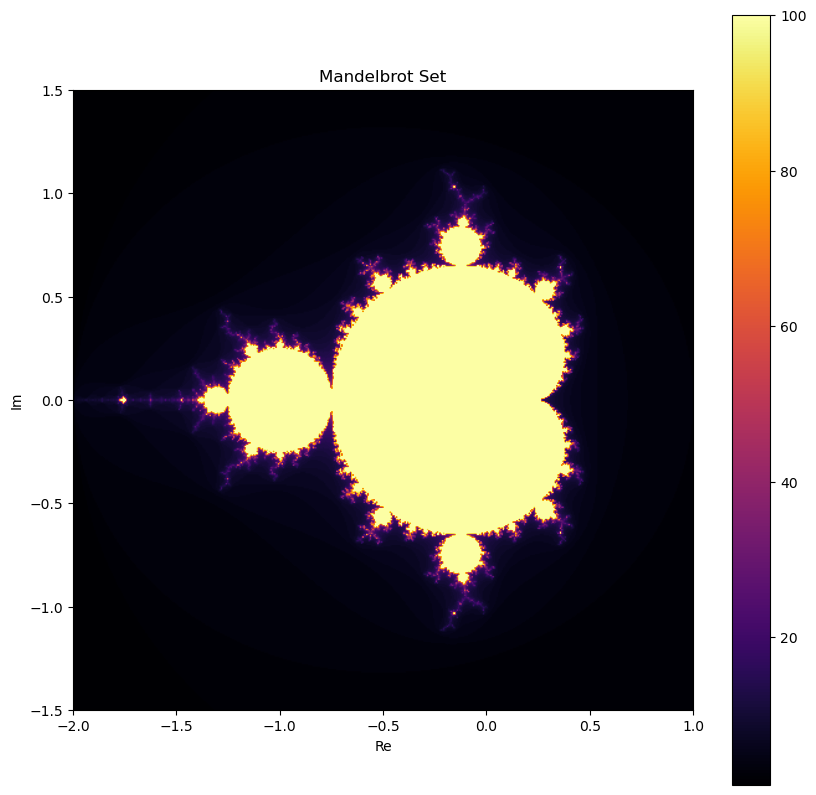

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


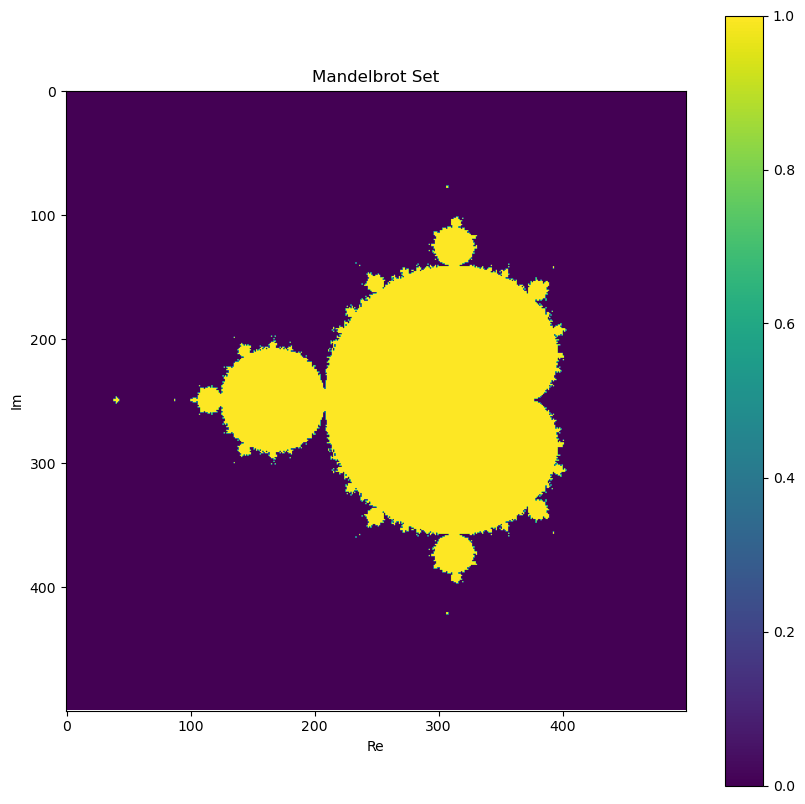

In [25]:
# Plot the Mandelbrot set with given parameters
plot_mandelbrot(500, 500, 100)

Part 2

In [26]:
def get_random_sample(sample_size,sampling_method="random"):
    # use latin hypercube sampling to sample points in the square
    if sampling_method == "latin":
        sampler = qmc.LatinHypercube(d=2,strength=1)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)

    # number of points needs to be p**2 where p is a prime number
    if sampling_method == "orthogonal":
        sampler = qmc.LatinHypercube(d=2,strength=2)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)
    
    # use pure random sampling
    if sampling_method == "random":
        sample_scaled = np.random.uniform(low=lowerBounds, high=upperBounds, size=(sample_size, 2))
    
    return sample_scaled

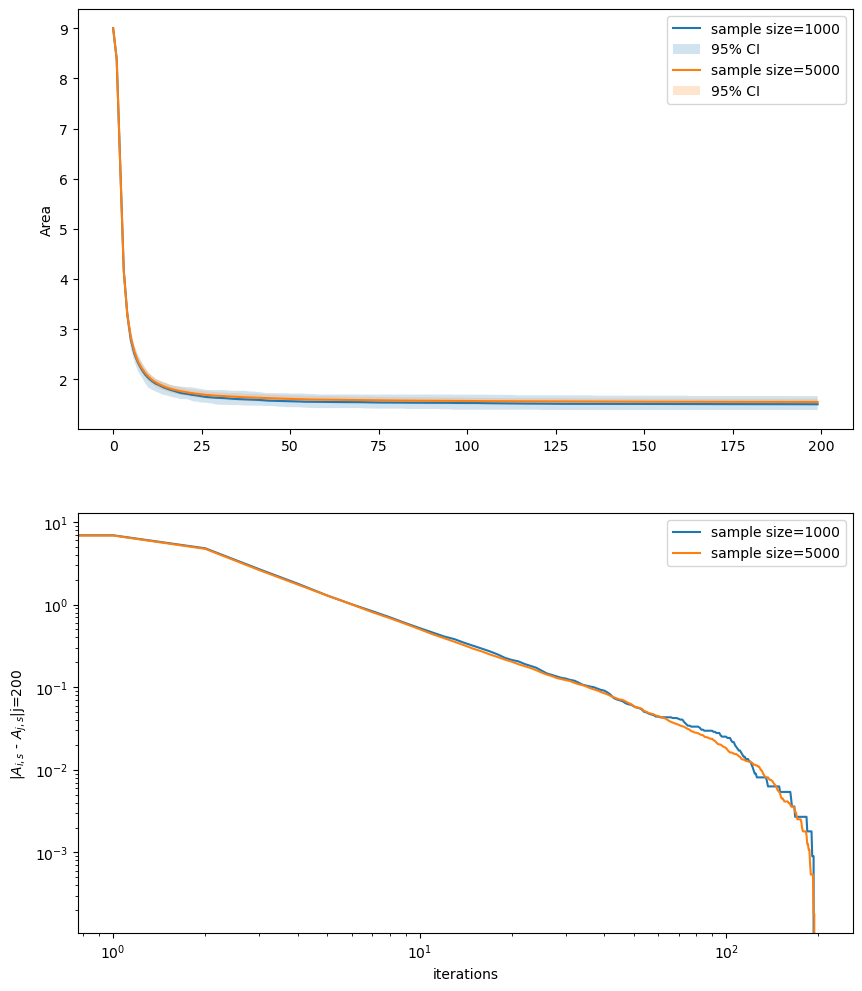

In [ ]:
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
max_iter = 200
#sample_sizes = [1000,5000,10000,50000]
sample_sizes = [1000,5000]
stoch_repeat = 10

fig, ax = plt.subplots(2,1,figsize=(10,12))

# we can do this for multiple runs to get a confidence interval
# check MC for one value of max_iter, do for multiple sample sizes
for sample_size in sample_sizes:
    areas_ss = []
    
    for _ in range(stoch_repeat):
        # get a random sample
        sample_scaled = get_random_sample(sample_size)
        areas = []

        # find area and convergence to area for given maximal iterations and sample size
        for iter in range(max_iter):
            mc_count = 0
            
            for i in range(sample_size):
                    z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
                
                    if abs(z) <= 2:
                        mc_count += 1
                    
            current_area = (float(mc_count) * area_of_region) / sample_size
            areas.append(current_area)
        
        areas = np.array(areas)
        areas_ss.append(np.array(areas))

    areas_ss = np.array(areas_ss)
    mean_areas = np.mean(areas_ss,axis=0)
    lower = np.percentile(areas_ss, 2.5, axis=0)
    upper = np.percentile(areas_ss, 97.5, axis=0)

    Ais_Ajs = abs(mean_areas-mean_areas[-1])
    
    ax[0].plot(np.arange(0,max_iter,1), mean_areas, label=f"sample size={sample_size}")
    ax[0].fill_between(np.arange(0,max_iter,1), lower, upper, alpha=0.2, label="95% CI")
    #ax[1].plot(np.arange(1,max_iter,1),abs(mean_areas-mean_areas[-1])[1::],label=f"sample size={sample_size}")
    ax[1].plot(np.arange(0,len(Ais_Ajs),1), Ais_Ajs,label=f"sample size={sample_size}")

ax[0].legend()
ax[0].set_ylabel("Area")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].legend()
ax[1].set_ylabel(r"|$A_{i,s}$ - $A_{j,s}$|"+ f" j={max_iter}")
ax[1].set_xlabel("iterations")
plt.show()


In [28]:
# Implementation of code in lecture slides, to determine sample size for a standard error of d

d = 0.05
max_iter = [5,10,25,50]
sample_size = 100
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1])
N = 20

samples_per_iter = []
for iter in max_iter:
    areas_ss = []
    samples_of_100_ss = []

    for stoch_repeat in range(N):
        areas = []
        samples_of_100 = 0
        sample_std = 10
        mc_count = 0

        # for _ in range(max_samples):
        while sample_std > d or len(areas) < 10:
            # add random samples of sample size 100
            sample_scaled = get_random_sample(sample_size)
            samples_of_100 += 1
            total_samplesize = 100 * samples_of_100

            # check by MC if inside or outside area
            for i in range(sample_size):
                z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)

                if abs(z) <= 2:
                    mc_count += 1
                
            current_area = (float(mc_count) * area_of_region) / total_samplesize

            areas.append(current_area)

            # calculate the sample's S/sqrt(n)
            sample_std = np.std(areas,ddof=1)

        print(samples_of_100)
        samples_of_100_ss.append(samples_of_100)
        areas = np.array(areas)
        areas_ss.append(areas)

    samples_per_iter.append(samples_of_100_ss)

    samples_of_100_ss = np.array(samples_of_100_ss)
    mean_samplesize = np.mean(samples_of_100_ss)
    lower = np.percentile(samples_of_100_ss, 2.5, axis=0)
    upper = np.percentile(samples_of_100_ss, 97.5, axis=0)


samples_per_iter = np.array(samples_per_iter) * 100
mean_samples_per_iter = np.mean(samples_per_iter, axis=1)
errors = np.std(samples_per_iter, axis=1, ddof=1)


45
277
330
266
33
1615
434
270
17
430
750
10
581
122
263
234
207
53
220
661
365
92
10
56
70
93
17
66
234
128
342
259
412
82
414
21
112
35
848
174
101
378
20
56
218
30
603
86
327
144
28
94
10
18
69
10
133
102
170
73
219
112
43
349
69
95
20
159
237
116
10
718
10
613
55
33
128
10
26
11


Text(0.5, 0, 'Iterations')

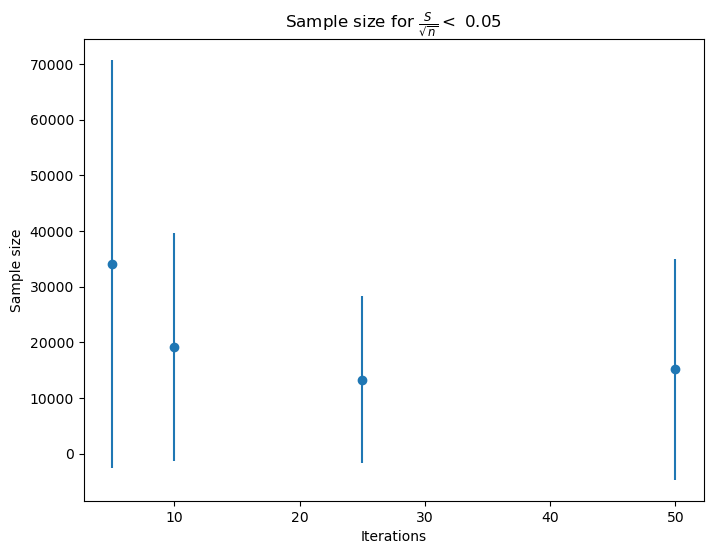

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(max_iter, mean_samples_per_iter, yerr=errors, fmt='o', label="{iter} iterations")
text = r"$\frac{S}{\sqrt{n}} < $"
ax.set_title(f"Sample size for {text} {d}")
ax.set_ylabel(r"Sample size")
ax.set_xlabel("Iterations")

Text(0, 0.5, '$A_i - A_{i-1}$')

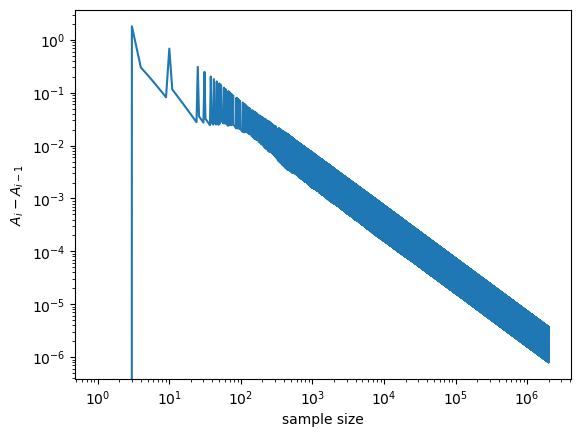

In [ ]:
# Choose a threshold for convergence and compare how the value for Area changes compared to previous Area
# Do we test convergence as a function of sample size? 

def find_convergence_samples(iter,sample_size):
    area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1])
    sample_scaled = get_random_sample(sample_size)
    areas = []
    mc_count = 0
    
    for i in range(1,sample_size):
        z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
                    
        if abs(z) <= 2:
            mc_count += 1
                        
        current_area = (float(mc_count) * area_of_region) / i
        areas.append(current_area)

    areas = np.array(areas)
    
    convergence = abs(np.diff(areas))

    return convergence

convergence = find_convergence_samples(50,2000000)

plt.yscale("log")
plt.xscale("log")
plt.plot(convergence)
plt.xlabel("sample size")
plt.ylabel(r"$A_i - A_{i-1}$")

# If we choose convergence at A_i - AI(i-1) = 10**(-4)
# We now need to test the convergence rate for the different sample techniques.